# Recycle Classification with ResNet

In [3]:
import torch
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from PIL import Image

## Create Recycle Dataset

In [5]:
# create custom dataset for image classification
class RecycleDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.label = []
        self.classes = (os.listdir(root_dir))
        self.train = train

        # create lists of the image paths and assign a int label to another list stepping through dir
        for i, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for folder in os.listdir(class_path):
                    subdir_path = os.path.join(class_path, folder)
                    if os.path.isfile(subdir_path):
                        self.image_paths.append(subdir_path)
                        self.label.append(i)
                    elif os.path.isdir(subdir_path):
                        for file in os.listdir(subdir_path):
                            self.image_paths.append(os.path.join(subdir_path, file))
                            self.label.append(i)

        # we want the same number of classes accross both training and test
        train_paths, test_paths, train_labels, test_labels = train_test_split(self.image_paths,
                                                                              self.label,
                                                                              test_size=.2,
                                                                              stratify=self.label, 
                                                                              random_state=42)
        # ability to create a test and train set
        if self.train:
            self.image_paths = train_paths
            self.label = train_labels
        else:
            self.image_paths = test_paths
            self.label = test_labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        class_label = self.label[idx]

        if self.transform:
            image = self.transform(image)

        return image, class_label

# transformation req by ResNet
root_dir = "Custom Data"
transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# creating datasets...
train_data = RecycleDataset(root_dir, transform=transformation)
test_data = RecycleDataset(root_dir, train=False, transform=transformation)

# example of raw data 
img, label = train_data[0]
print(f"Raw image data:\n{img} \nRaw label: {label}")
print(f"Raw image data shape: {img.shape}")

Raw image data:
tensor([[[ 0.2282, -0.4739, -0.2171,  ...,  1.6838,  1.6667,  1.6324],
         [ 0.7933, -0.2171, -0.3883,  ...,  1.5125,  1.5810,  1.5810],
         [ 0.8789,  0.6906, -0.3883,  ...,  0.0912,  0.6563,  0.9132],
         ...,
         [ 1.2214,  1.2385,  1.2043,  ...,  0.6392,  1.0502, -1.0390],
         [ 1.2214,  1.2557,  1.2557,  ...,  0.7419,  1.2385, -0.6794],
         [ 1.2557,  1.2899,  1.2899,  ...,  0.6563,  1.3242, -0.5253]],

        [[ 0.3102, -0.9853, -0.5826,  ...,  1.6232,  1.6057,  1.5707],
         [ 0.9930, -0.3025, -1.0028,  ...,  1.4657,  1.5182,  1.5182],
         [ 1.0630,  0.8529, -0.7752,  ...,  0.0126,  0.5728,  0.8354],
         ...,
         [ 0.6604,  0.6779,  0.6429,  ...,  0.2227,  0.6604, -1.3704],
         [ 0.6954,  0.6954,  0.7129,  ...,  0.3452,  0.9230, -1.0553],
         [ 0.6954,  0.7129,  0.7479,  ...,  0.3102,  0.9930, -0.8978]],

        [[ 0.4265, -1.4733, -0.8458,  ...,  1.5594,  1.5420,  1.5420],
         [ 1.2805, -0.3753, -

## Create Dataloader For Model

In [7]:
# create dataloader obj with batch 32 for model
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Show how many batches we have 
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Length of train_dataloader: 18 batches of 32


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Plotting Functions

In [9]:
# function to convert img tensor to numpy and denormalize and show images
def imshow(inp, title=None):
    """"Convert tensor to array to display single image"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

# function to plot grid of images with ability to show predictions or not
def plot_images(data, classes, model=None, predict=False):
    """ Plots 32 images with prediction"""
    fig = plt.figure(figsize=(24,12))

    for i in range(1,33):
        randidx = torch.randint(0, len(data), size=[1]).item()
        img, truth_label = data[randidx]

        if predict:
            img = img.unsqueeze(0).to(device) # model expects [B, C, H, W]
            output = model(img)
            _, pred = torch.max(output,1)          
            img = img.squeeze().cpu()
            fig.add_subplot(4, 8, i)
            imshow(img)
            title_text = f"Pred: {classes[pred]} \n Truth: {classes[truth_label]}"
            if pred == truth_label:
                plt.title(title_text, fontsize=10, c="g")
            else:
                plt.title(title_text, fontsize=10, c="r")
          
        else:
            fig.add_subplot(4,8, i)
            imshow(img)
            plt.title(classes[truth_label])
            
        plt.axis("off")

### Plotting Some Images

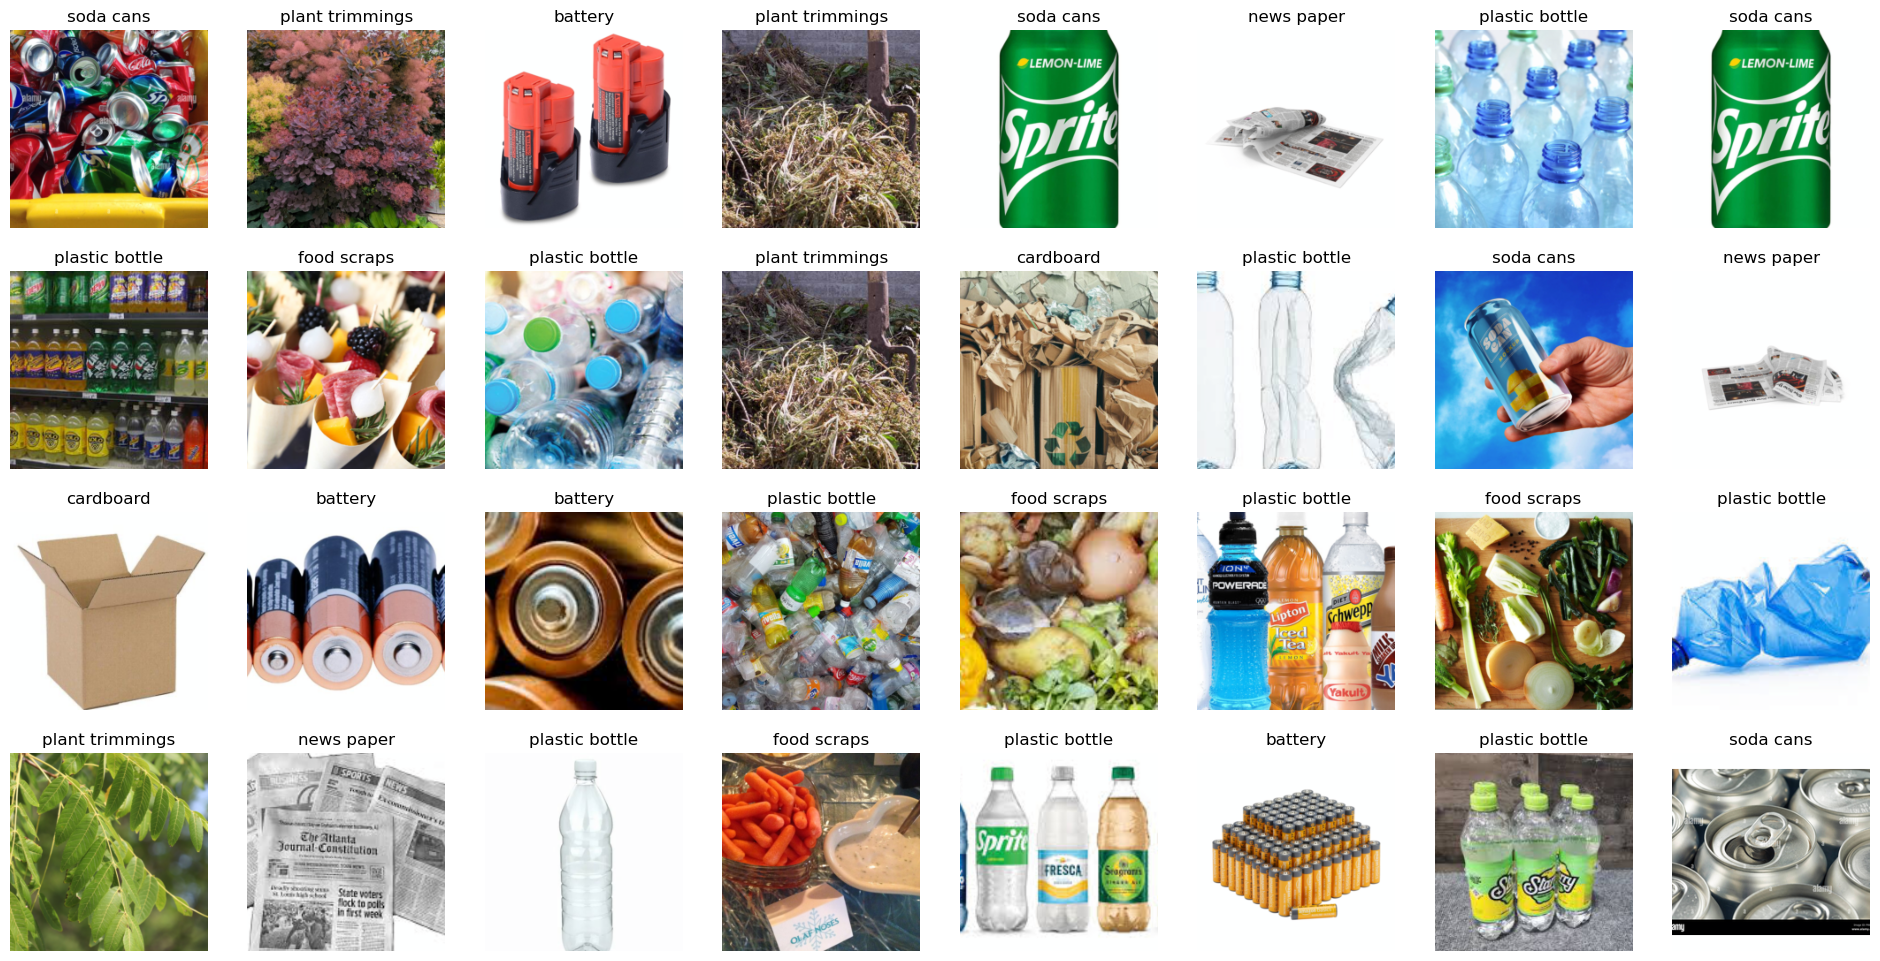

In [11]:
classes = train_data.classes
plot_images(data=train_data, classes=classes)

## Create the Model

In [13]:
# GPUUUUUUUUUU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Transfer learning with pretrained weights. Tunes only the last layer
ResNet50 = torchvision.models.resnet50(weights="IMAGENET1K_V1")
for param in ResNet50.parameters():
    param.requires_grad = False

# Change with the number of classes we have
ResNet50.fc = nn.Linear(2048, len(classes))

# loss function and optimizer setup
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ResNet50.parameters(), lr=0.001, momentum=0.9)
ResNet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Build Training/ Val Loop

In [15]:
import torch.optim.lr_scheduler as lr_scheduler

def train_and_val(model, train_loader, test_loader, loss_fn, optimizer, parameter_path, num_epochs=3):
    model_params = parameter_path

    # save weights and biases to local dir
    torch.save(model.state_dict(), model_params)

    # Define a learning rate scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=.1, patience=5)

    best_val_accuracy = 0.0
    best_model_wts = None
    for epoch in range(num_epochs):

        # Training loop
        model.train()
        
        running_loss = 0.0
        running_correct = 0
        total_train = 0
        
        for img, label in train_loader:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = loss_fn(outputs, label)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * img.size(0)
            running_correct += torch.sum(preds == label.data)
            total_train += label.size(0)
              
        epoch_loss = running_loss / total_train
        epoch_acc = running_correct.double() / total_train

        model.eval()
        val_running_loss = 0.0
        val_running_correct = 0
        total_val = 0

        # Testing Loop
        with torch.inference_mode():
            for img, label in test_loader:
                img, label = img.to(device), label.to(device)
                outputs = model(img)
                loss = loss_fn(outputs, label)
                _, preds = torch.max(outputs, dim=1)
                val_running_loss += loss.item() * img.size(0)
                val_running_correct += torch.sum(preds == label.data)
                total_val += label.size(0)
                
        val_loss = val_running_loss / total_val
        val_acc = val_running_correct.double() / total_val

        last_lr = scheduler.get_last_lr()[0]
        
        print(f"Epoch {epoch+1} / {num_epochs}")
        print("-" * 15)
        print(f"Learning Rate set to: {last_lr}")
        print(f"Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f}")
        print(f"Test Loss: {val_loss:.4f} | Test Accuracy: {val_acc:.4f}\n")

        scheduler.step(val_loss)
        
        # Saves only the trial with the best weights 
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), model_params)
            
    print(f"Best accuracy: {best_val_accuracy}")

In [31]:
train_and_val(ResNet50, train_dataloader, test_dataloader, loss_fn, optimizer, "ReNet50_params.pth", num_epochs=5)

Epoch 1 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.5010 | Training Accuracy: 0.9120
Test Loss: 0.4151 | Test Accuracy: 0.9286

Epoch 2 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.4279 | Training Accuracy: 0.9174
Test Loss: 0.3634 | Test Accuracy: 0.9571

Epoch 3 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.3921 | Training Accuracy: 0.9228
Test Loss: 0.3255 | Test Accuracy: 0.9571

Epoch 4 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.3288 | Training Accuracy: 0.9551
Test Loss: 0.3027 | Test Accuracy: 0.9571

Epoch 5 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.3130 | Training Accuracy: 0.9533
Test Loss: 0.2823 | Test Accuracy: 0.9714

Best accuracy: 0.9714285714285714


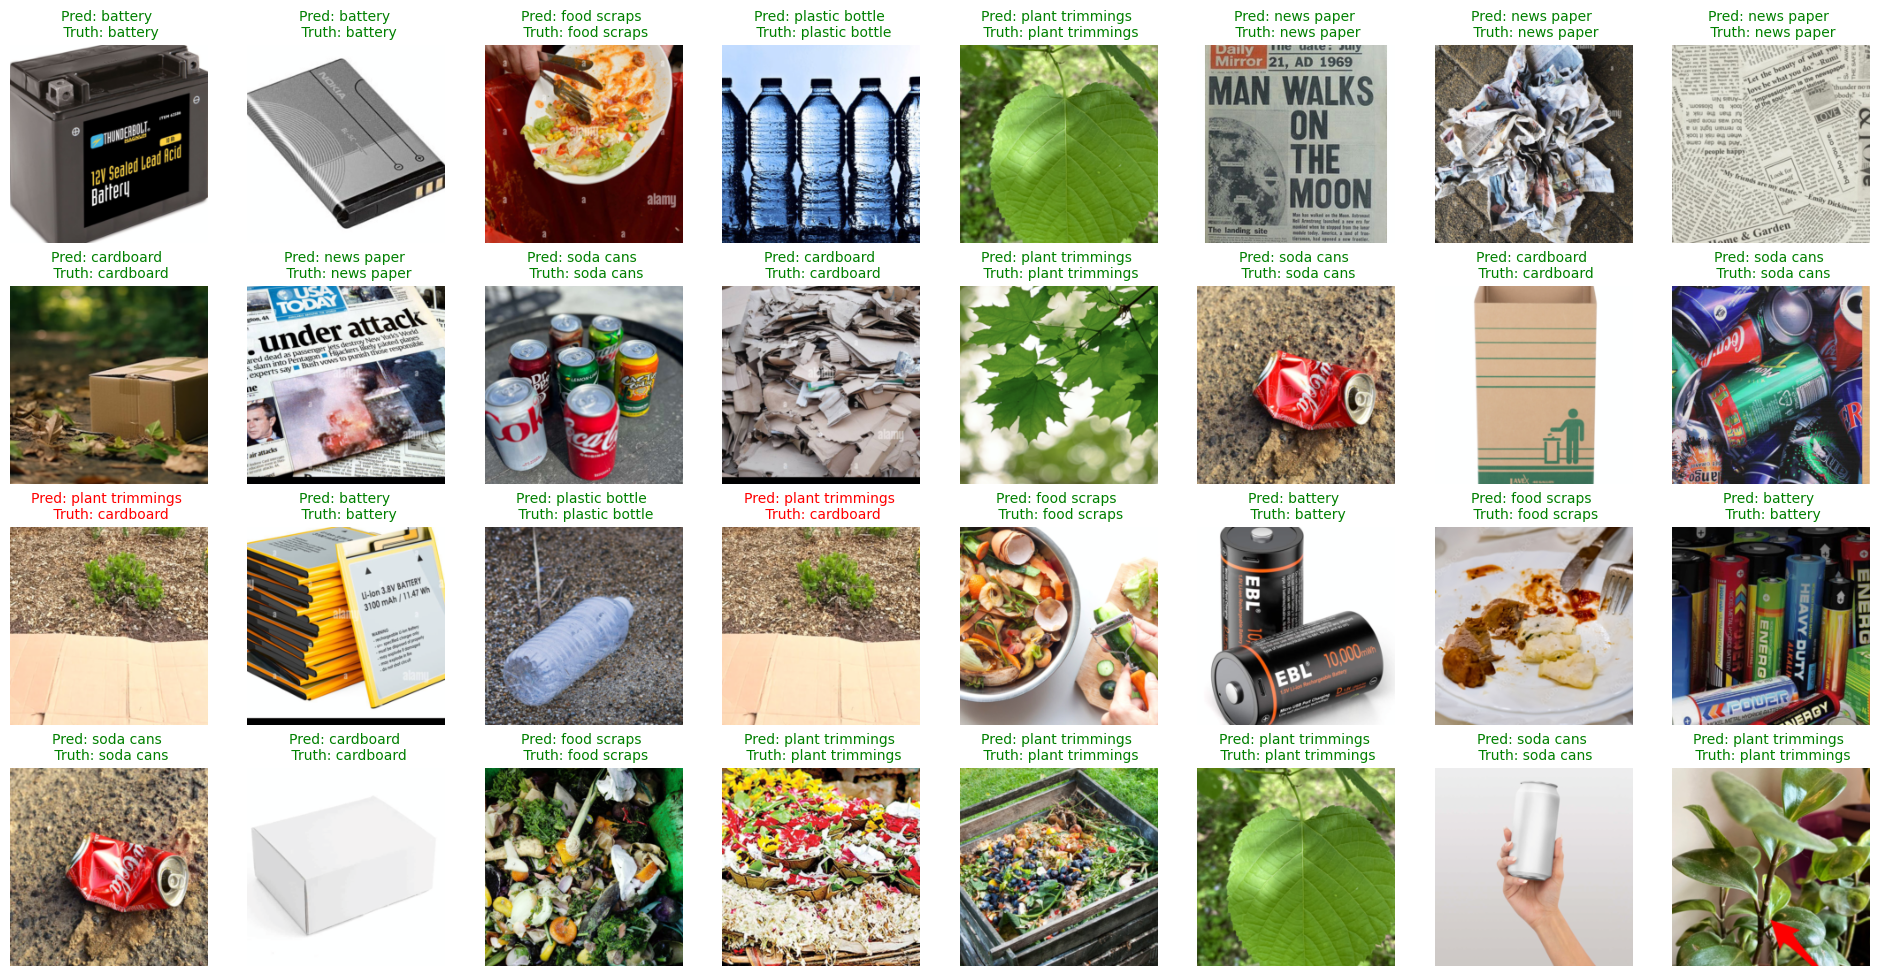

In [47]:
ResNet50.load_state_dict(torch.load("ReNet50_params.pth", weights_only=True))
plot_images(model=ResNet50, data=test_data, classes=train_data.classes, predict=True)

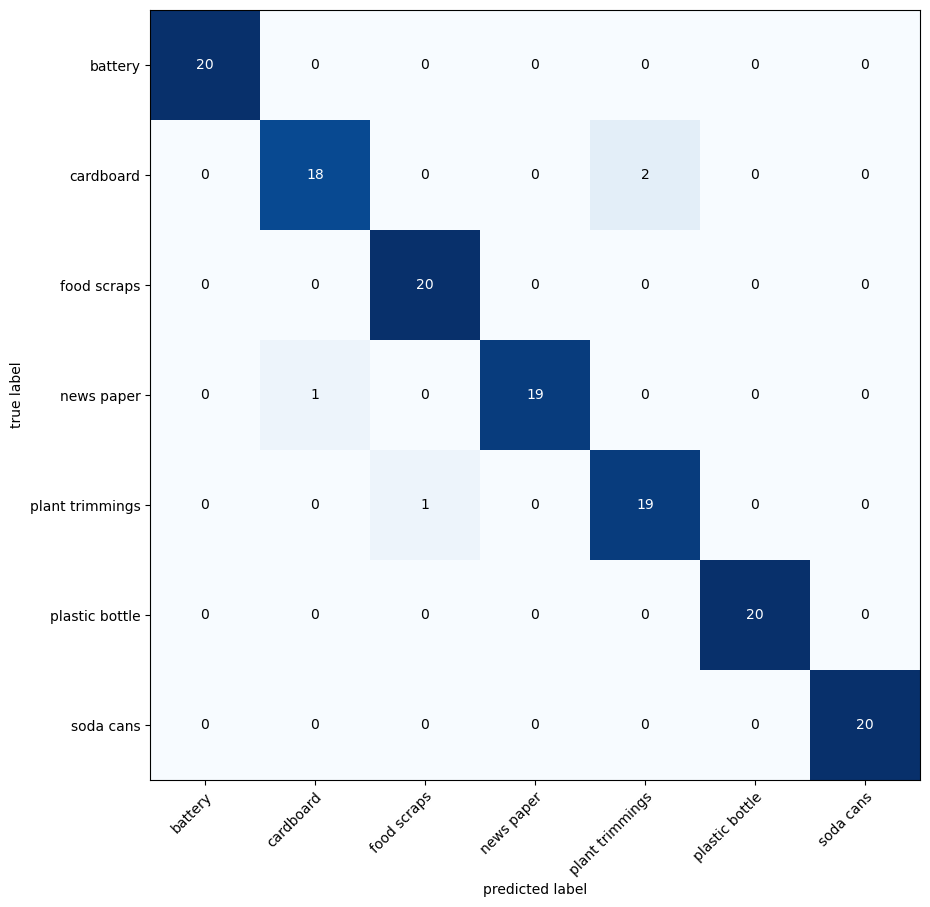

In [45]:
from torchmetrics import ConfusionMatrix, Accuracy

y_preds = []
y_true = []
ResNet50.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        output = ResNet50(X)
        _, pred = torch.max(output, dim=1)
        y_preds.append(pred.cpu())
        y_true.append(y.cpu())

y_preds_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

confmat = ConfusionMatrix(num_classes=len(classes), task="multiclass")
confmat_tensor = confmat(preds=y_preds_tensor, target=y_true_tensor )

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names = classes,
    figsize=(10,10)
)

In [39]:
accuracy = Accuracy(task="multiclass",
                   num_classes=len(classes))
print(f"Accuracy: {accuracy(y_preds_tensor, y_true_tensor)*100:.2f}")

Accuracy: 97.14


## EffNetB2

In [21]:
effnet_transform = transforms.Compose([
    transforms.Resize(288),
    transforms.CenterCrop(288),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, .225])
])

effnet_train_data = RecycleDataset(root_dir, transform=effnet_transform)
effnet_test_data = RecycleDataset(root_dir, transform=effnet_transform, train=False)

In [22]:
effnet_train_dataloader = DataLoader(effnet_train_data, batch_size=BATCH_SIZE, shuffle=True)
effnet_test_dataloader = DataLoader(effnet_test_data, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
EffNetB2 = torchvision.models.efficientnet_b2(weights="DEFAULT")

In [24]:
for param in EffNetB2.parameters():
    param.requires_grad = False

In [25]:
EffNetB2.classifier[1] = nn.Linear(1408, len(classes))

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(EffNetB2.parameters(), lr=0.001, momentum=0.9)
EffNetB2.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [56]:
train_and_val(EffNetB2, effnet_train_dataloader, effnet_test_dataloader, loss_fn, optimizer, "EffNetB2_params.pth", num_epochs=5)

Epoch 1 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.3134 | Training Accuracy: 0.9045
Test Loss: 0.4287 | Test Accuracy: 0.8817

Epoch 2 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.3162 | Training Accuracy: 0.9019
Test Loss: 0.4237 | Test Accuracy: 0.8824

Epoch 3 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.3144 | Training Accuracy: 0.9058
Test Loss: 0.4340 | Test Accuracy: 0.8767

Epoch 4 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.3191 | Training Accuracy: 0.8971
Test Loss: 0.4226 | Test Accuracy: 0.8836

Epoch 5 / 5
---------------
Learning Rate set to: 0.001
Training Loss: 0.3139 | Training Accuracy: 0.9041
Test Loss: 0.4223 | Test Accuracy: 0.8793

Best accuracy: 0.8835714285714286


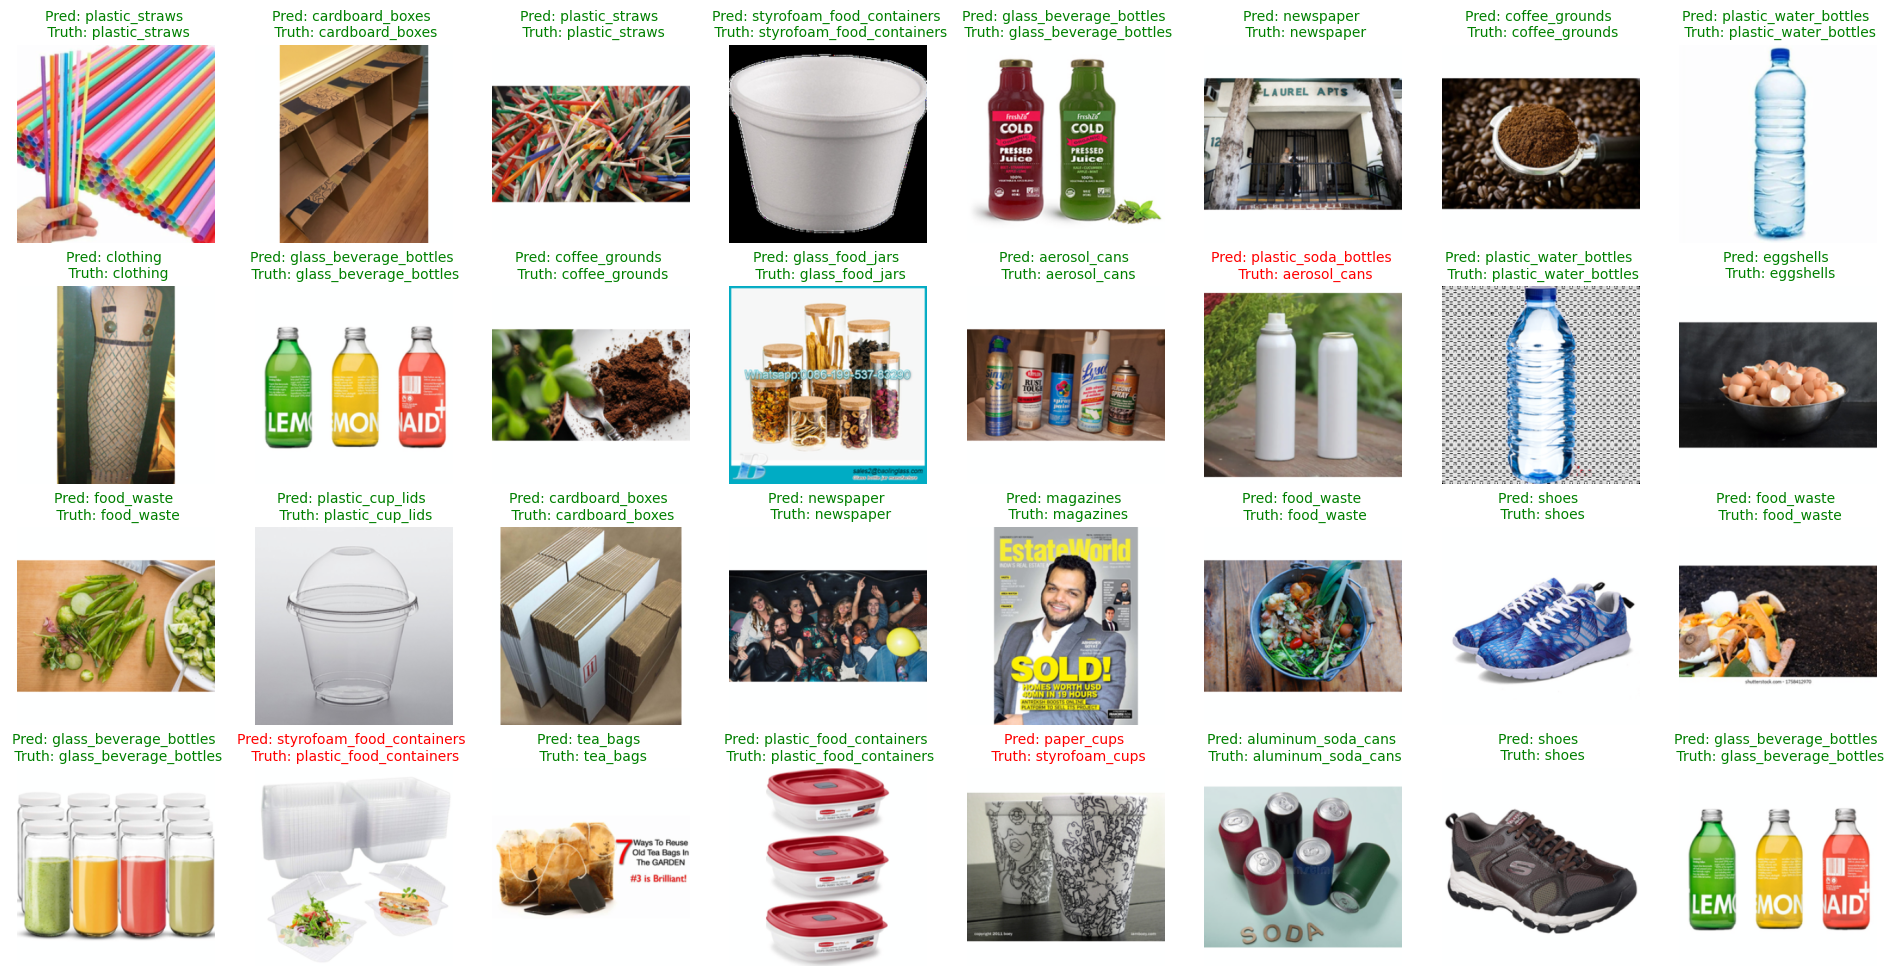

In [62]:
EffNetB2.load_state_dict(torch.load("EffNetB2_params.pth", weights_only=True))
plot_images(effnet_test_data, classes=classes, model=EffNetB2, predict=True)